# Salary Expectation in Relation to Job Position or Title
In the following notebook, we will be examining the relationship between expected income and job position. We do not feel the need to prove that in general, your salary has a direct relation to your title and job position. Therefore, we hope that our data emulates this expected result.

We'll be taking a look at not only the expected salary of positions over time. From this, we can infer positions with high fluctuation in total compensation over time, as well as positions that remain relatively stable. We can also understand which positions receive high total compensation in general. We expect that managerial positions will receive higher total compensation, as they require more experience generally.

In [1]:
#Let's read in our packages
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession, Row
from pyspark import SparkConf

import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Instantiate a spark session
spark = SparkSession \
    .builder \
    .appName("Spark Job-Level Salary Analysis") \
    .getOrCreate()

## Data Preparation
We have a few data preparation tasks that we must take care of. Firstly, we would like to see exactly how many positions are in our dataset. Depending on this feature, we will either analyse the whole set, or subset of our data at each point.

We must then break down our positions into smaller subdivisions, possibly by a temporal dimension. This will allow us to compare how the expected income for a position changes over time.

In [5]:
# Let's define our schema
schema = StructType([\
    StructField("date", DateType(), True),\
    StructField("time", StringType(), True),\
    StructField("company", StringType(), True),\
    StructField("level", StringType(), True),\
    StructField("title", StringType(), True),\
    StructField("totalyearlycompensation", IntegerType(), False),\
    StructField("location", StringType(), True),\
    StructField("yearsofexperience", FloatType(), False),\
    StructField("yearsatcompany", FloatType(), False),\
    StructField("tag", StringType(), True),\
    StructField("basesalary", IntegerType(), False),\
    StructField("stockgrantvalue", IntegerType(), False),\
    StructField("bonus", IntegerType(), False),\
    StructField("gender", StringType(), True),\
    StructField("cityid", StringType(), True),\
    StructField("dmaid", StringType(), True),\
    StructField("race", StringType(), True),\
    StructField("education", StringType(), True)])

# Load and parse the data file, converting it to a DataFrame.
data = spark.read.format("csv")\
    .option("header", "false")\
    .option("delimiter", "\t")\
    .schema(schema)\
    .load("../data/seperated_time_data/cleaned.txt")
data.show(n=5)

+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|      date|    time|  company|level|               title|totalyearlycompensation|         location|yearsofexperience|yearsatcompany|tag|basesalary|stockgrantvalue|bonus|gender|cityid|dmaid|race|education|
+----------+--------+---------+-----+--------------------+-----------------------+-----------------+-----------------+--------------+---+----------+---------------+-----+------+------+-----+----+---------+
|2017-06-07|   11:33|   ORACLE|   L3|     Product Manager|                 127000| Redwood City, CA|              1.5|           1.5| NA|    107000|          20000|10000|    NA|  7392|  807|  NA|       NA|
|2017-06-10|   17:11|     EBAY| SE 2|   Software Engineer|                 100000|San Francisco, CA|              5.0|           3.0| NA|    141907|              0|    0|    NA

In [6]:
#How many unique titles do we have
data.select(countDistinct('title')).show()

+---------------------+
|count(DISTINCT title)|
+---------------------+
|                   15|
+---------------------+



As we only have 15 unique titles to choose from, we can perform analysis on our entire dataset. This is beneficial, as at no point will we need to subdivide our available positions using assumptions of their inherit importance to our analysis. Let's now extend our data to perform our first simple analysis:

**Expected income per title by quarter**.

We will discuss why we aggregate into quarters of the year later. For now, let's look at the representation of titles in our data.

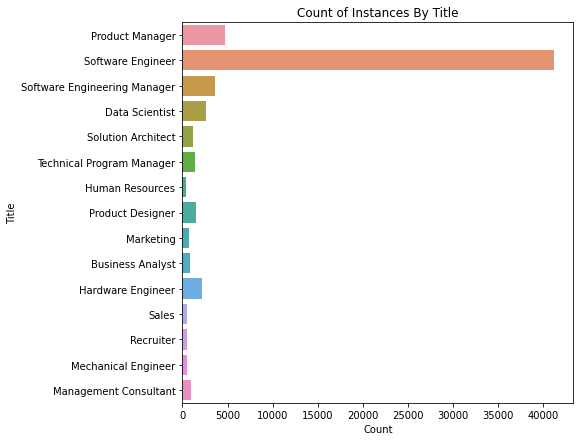

In [7]:
#Count occurences of each title
counts = data.groupby('title').count()

#Convert to pandas and visualise
counts = data.toPandas()

plt.figure(figsize=(7,7))
plt.title('Count of Instances By Title')
ax = sns.countplot(y='title', data=counts)

plt.ylabel('Title')
plt.xlabel('Count')
plt.savefig("../Graph Outputs/instances-by-title.png" ,bbox_inches='tight')
plt.show()

It's clear that *Software Engineer* is an over-represented title in our data. However, there still remains sufficient instances of each title, meaning we will not exclude any position from analysis.

In [8]:
#Add quarter column
data = data.withColumn('quarter', quarter('date'))

In [9]:
#Let's groupby title, year, and quarter, then avg our monetary values
expec_sal_by_title = data.groupby('title', data['date'].substr(0,4),
                                'quarter').avg().collect()

#Convert to dataframe
expec_sal_by_title = spark.createDataFrame(expec_sal_by_title)

#fix column names
expec_sal_by_title = expec_sal_by_title.withColumnRenamed("avg(totalyearlycompensation)","total comp") \
    .withColumnRenamed("quarter","quarter") \
    .withColumnRenamed("substring(date, 0, 4)","year") \
    .withColumnRenamed("avg(yearsofexperience)","years_experience") \
    .withColumnRenamed("avg(yearsatcompany)","years_at_company") \
    .withColumnRenamed("avg(bonus)","bonus") \
    .withColumnRenamed("avg(stockgrantvalue)","sg value") \
    .withColumnRenamed("avg(basesalary)","base salary")

#Round all our floats down to 1 decimal place
#Now we want to round all our values to 1 decimal place
for c in expec_sal_by_title.columns[1:]:
    expec_sal_by_title = expec_sal_by_title.withColumn(c, round(c, 1))

#Convert year & month to int
expec_sal_by_title = expec_sal_by_title.withColumn("year", expec_sal_by_title["year"].cast(IntegerType()))
expec_sal_by_title = expec_sal_by_title.withColumn("quarter", expec_sal_by_title["quarter"].cast(IntegerType()))
expec_sal_by_title.show(n=5)

+--------------------+----+-------+----------+----------------+----------------+-----------+--------+-------+------------+
|               title|year|quarter|total comp|years_experience|years_at_company|base salary|sg value|  bonus|avg(quarter)|
+--------------------+----+-------+----------+----------------+----------------+-----------+--------+-------+------------+
|   Hardware Engineer|2019|      4|  235323.8|             7.9|             4.0|   151828.6| 59904.8|23571.4|         4.0|
|           Marketing|2019|      1|  275000.0|            15.0|             9.3|   200000.0| 20000.0|52500.0|         1.0|
|Management Consul...|2020|      4|  161434.5|             6.6|             3.1|   134062.1|  2931.0|17496.8|         4.0|
|Software Engineer...|2017|      2|  297400.0|            10.6|             5.9|   180200.0| 91000.0|59200.0|         2.0|
|Management Consul...|2020|      2|  150508.9|             6.0|             2.5|   130678.6|  2214.3|17750.0|         2.0|
+---------------

We know our data operates from **June '17 to August '21**, which translates to 3 months and 4 years, or 51 months. This means, for each title, we have a total of 51 data points. Some titles do not have data from June '17, and so will not have 51 data points, whilst others may have missing months irregularly.

Nonetheless, 51 data points for 15 titles will create a messy visualisation with too much going on. We would like to aggregate our data down to *quarters* where:
* First Quarter: Jan, Feb, March
* Second Quarter: April, May, June
* Third Quarter: July, Aug, Sep
* Fourth Quarter: Oct, Nov, Dec

We used the `quarter()` function on our raw data earlier to add a quarter column by using our date column. In the following cells, we will convert to pandas DataFrame before visualising our results.

In [10]:
#Let's convert to pandas before graphing
pandasdf1 = expec_sal_by_title.toPandas()

In [11]:
pandasdf1.year = pandasdf1['year'].astype(str)
pandasdf1.quarter = pandasdf1['quarter'].astype(str)
pandasdf1['period'] = pandasdf1[['year', 'quarter']].agg('-'.join, axis=1)
pandasdf1.drop(columns=['avg(quarter)'], inplace=True)

In [12]:
#Next we pivot to better represent our datta
pandasdf1 = pandasdf1.pivot('period', 'title', 'total comp')

In [13]:
pandasdf1.tail(3)

title,Business Analyst,Data Scientist,Hardware Engineer,Human Resources,Management Consultant,Marketing,Mechanical Engineer,Product Designer,Product Manager,Recruiter,Sales,Software Engineer,Software Engineering Manager,Solution Architect,Technical Program Manager
period,,,,,,,,,,,,,,,
2021-1,129930.6,208298.1,224938.8,179318.7,172700.5,211876.2,158932.0,210418.5,267494.1,178000.0,221377.4,200584.3,357739.0,196708.6,235733.6
2021-2,135787.1,192384.1,199679.9,154512.2,168656.4,186245.0,186050.8,201651.4,259082.1,153300.0,204098.0,192777.8,348169.9,214490.4,230821.2
2021-3,139988.9,197089.8,191124.6,198968.8,151843.1,194890.1,148263.2,193457.6,244749.4,144541.7,223300.0,183860.4,309250.0,200400.0,240048.1


In [14]:
pandasdf1.shape

(18, 15)

## Total Compensation over Time per Title
We can now see that our dataframe consists of 18 data points for each of our 15 titles. This is a much more digestable dataset and will create a visualisation that is more interpretable and easy on the eyes.

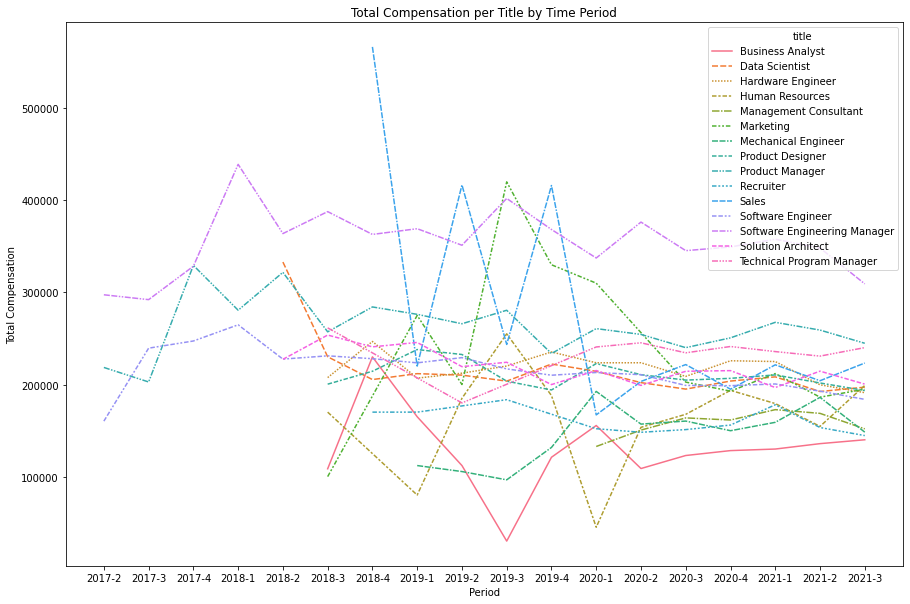

In [15]:
plt.figure(figsize=(15,10))
plt.xlabel('Period')
plt.ylabel('Total Compensation')

ax = sns.lineplot(data=pandasdf1)
plt.title("Total Compensation per Title by Time Period")
plt.show()

Although somewhat difficult to follow, we can gather that more or less all positions offer total compensation in the range of $[120000, 280000]$ by the third quarter of 2021.

Sales is by far the most unstable position in our dataset. In 2019, total compensation for sales positions fluctuate enourmously. This could indicate that we do not have much data relevent to this position at this period of time. Eventually, the expected salary for Sales begins to level out in 2020.

It appears that over the 5 year period, Software Engineering Manager remains the most lucrative STEM position according to our data.

---
## Individual Plots

We'll make an individual plot for each title in the following cell.

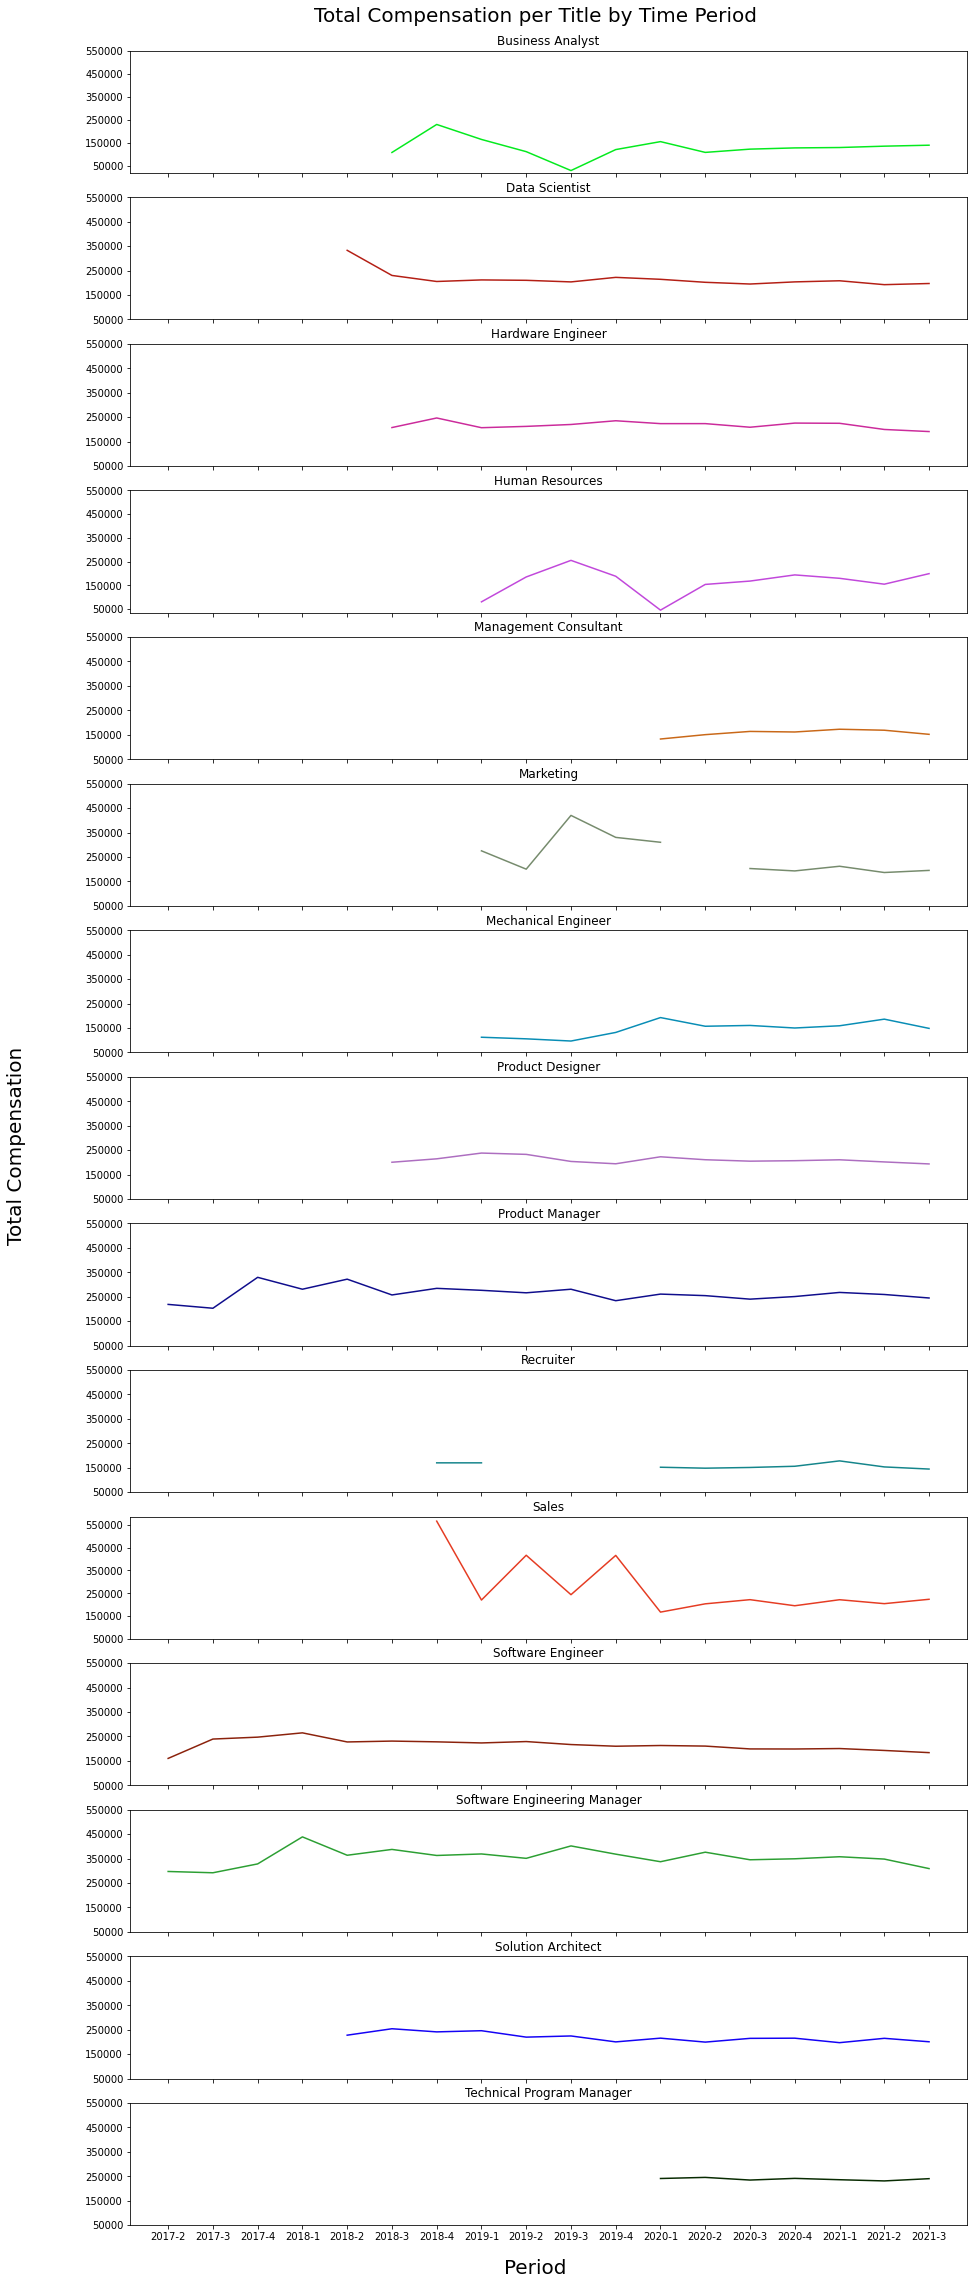

In [16]:
import random
#make subplots
fig, axs = plt.subplots(15,1,figsize=(15,40), sharex=True)
for i in range(0, len(axs)):
    r = random.random()
    b = random.random()
    g = random.random()
    color = (r, g, b)
    axs[i].plot(pandasdf1.index, pandasdf1.iloc[:,i], color = color)
    axs[i].set_title(pandasdf1.columns[i])

    
#setting y scale
plt.setp(axs, yticks=np.arange(50_000, 650_000,100_000))

#Setting Title
fig.text(0.5, 0.89, "Total Compensation per Title by Time Period", fontsize=20, ha="center")

#Setting axes labels
fig.text(0.5, 0.11, 'Period', ha='center', va='center', fontsize=20)
fig.text(0.02, 0.5, 'Total Compensation', ha='center', va='center', rotation='vertical', fontsize=20)
plt.savefig("../Graph Outputs/comp-per-title.png", bbox_inches='tight')
plt.show()

### Subplots Analysis
The above subplots give us clear indication of where our data may be lacking information. Some positions such as *Recruiter* have clear missing periods of time, as well as having considerbly less historical information. On the other hand, some positions such as *Data Scientist*, *Software Engineer*, and *Software Engineer Manager* are clearly well defined with historical data.

Outputing all of our different titles on the same y-axis allows us to view the total compensation distributions much more easily. We notice that in most cases, the total compensation remains relatively stable. This is not the case for the *Sales* title, which shows major fluctuation in 2019.

It is clear that according to our data, *Software Engineering Manager* is the highest paid position. This makes sense, as managerial positions usually require more experience, and therefore pay more. On the opposite end of the scale, we observe that *Human Resource* positions receive relatively low total compensation in comparison to other titles.

---

# Conclusion
In this Jupyter Notebook, we performed a simplistic analysis of of total compensation by title over a period of 5 years. We note that although our dataset is large, it is over-representative of particular titles such as *Software Engineer*. Less well represented positions suffer from a lack of data, and therefore disallow for visualisation-based inference.

We conclude that total compensation expectations on a global scale are related to job title. In our data, *Software Engineering Manager* receives the highest compensation, which is to be expected as it's the only managerial position in our dataset. As well as this, *Human Resources* receives the lowest total compensation.

It's good news for us data scientists, as according to our information, the total compensation for *Data Scientists* remains stable, hovering around $250,000 dollars annually.